In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.layers import Embedding, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Input, GlobalMaxPooling1D
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split #
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import normalize, OneHotEncoder

## Nacitanie

In [ ]:
dataset = pd.read_csv('../Data/final_dataset_cnt.csv')

In [ ]:
dataset.shape

(816, 2)

## Rozdelenie dat na sady

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['processed_text'], dataset['author_id'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

## One hot encoding

In [ ]:
one_hot_encoder = OneHotEncoder()

y_train = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()
y_valid = one_hot_encoder.transform(y_valid.to_numpy().reshape(-1, 1)).toarray()
y_test = one_hot_encoder.transform(y_test.to_numpy().reshape(-1, 1)).toarray()

In [ ]:
one_hot_encoder.categories_[0]

array([  17,   45,   65,   69,  120,  204,  213,  410,  505,  585,  594,
        791, 1060, 1181, 1230, 1626, 1758, 3141, 5166, 8137])

In [ ]:
index_to_id_mapping = {index: author_id for index, author_id in enumerate(one_hot_encoder.categories_[0])}

In [ ]:
index_to_id_mapping

{0: 17,
 1: 45,
 2: 65,
 3: 69,
 4: 120,
 5: 204,
 6: 213,
 7: 410,
 8: 505,
 9: 585,
 10: 594,
 11: 791,
 12: 1060,
 13: 1181,
 14: 1230,
 15: 1626,
 16: 1758,
 17: 3141,
 18: 5166,
 19: 8137}

# TextVectorization

## Model 1 - extra vacsi vocab_size

In [ ]:
embedding_dim = 256
vocab_size = 70000
sequence_length = 8000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

In [ ]:
input_layer = Input(shape=(1,), dtype=tf.string)
x_v = vect_layer(input_layer)
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(x_v)
x = tf.keras.layers.Conv1D(512, kernel_size=4, padding="valid", activation="relu")(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 8000)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 8000, 256)         17920000  
                                                                 
 conv1d (Conv1D)             (None, 7997, 512)         524800    
                                                                 
 max_pooling1d (MaxPooling1  (None, 3998, 512)         0         
 D)                                                              
                                                                 
 global_average_pooling1d (  (None, 512)               0     

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=15, batch_size = 16, callbacks=[model_checkpoint_callback])

Epoch 1/15
37/37 [==============================] - 17s 241ms/step - loss: 2.7754 - accuracy: 0.1672 - val_loss: 2.5736 - val_accuracy: 0.2273
Epoch 2/15
37/37 [==============================] - 7s 197ms/step - loss: 2.2155 - accuracy: 0.2713 - val_loss: 2.2861 - val_accuracy: 0.2273
Epoch 3/15
37/37 [==============================] - 7s 183ms/step - loss: 1.8974 - accuracy: 0.3652 - val_loss: 1.9499 - val_accuracy: 0.3636
Epoch 4/15
37/37 [==============================] - 7s 182ms/step - loss: 1.4050 - accuracy: 0.5512 - val_loss: 1.6026 - val_accuracy: 0.4697
Epoch 5/15
37/37 [==============================] - 7s 184ms/step - loss: 0.9557 - accuracy: 0.7082 - val_loss: 1.2345 - val_accuracy: 0.6667
Epoch 6/15
37/37 [==============================] - 7s 184ms/step - loss: 0.6590 - accuracy: 0.8225 - val_loss: 1.0861 - val_accuracy: 0.6970
Epoch 7/15
37/37 [==============================] - 7s 186ms/step - loss: 0.4961 - accuracy: 0.8515 - val_loss: 0.9553 - val_accuracy: 0.7273
Epoch

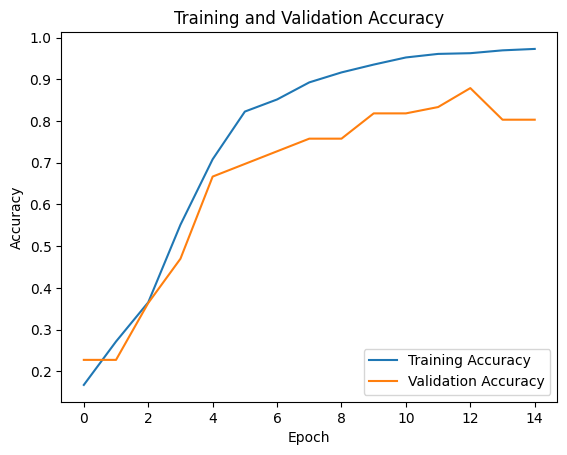

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

6/6 [==============================] - 1s 111ms/step
[ 3 16 15 11  6 15  3  4  4  6 12 17  9 15  5  7  1 14 13  6  8 12 11 15
 10 10  6  3  3 12  4 11  2  2 17 10  3 13 12  1 12  6 13  8 11  3  6  5
  6  9 19 15 17 17  7  1  4 12  1 17 19 19  8 18  3  3 19 10 14  8 16 13
  3 15 10 10 19 16  1 19  3 15 13 12 12 15  6  3  5 19  6  4  6  5  4 18
 13  9 19  3  6 10 15  2  2  5 14 13 12  5  6 15  5  6 13  6 12 10 17 14
 15 13  3 19 13  2  8 17  2 10 13 17  4 16 12 16 15 13 17 13  9 13  4 18
  4 19 10 17 14  9 19  7  1 10 19  2 13 15 15 13 15 17  9 17]


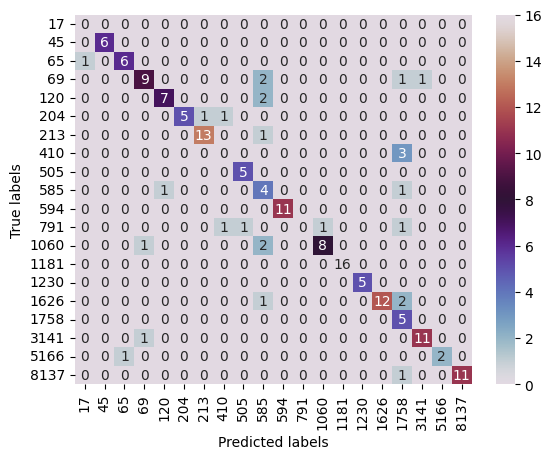

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)

print(y_true)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

y_pred_ids = [index_to_id_mapping[label] for label in y_pred_labels]
y_true_ids = [index_to_id_mapping[label] for label in y_true_labels]

conf_matrix = confusion_matrix(y_true_ids, y_pred_ids, labels=list(index_to_id_mapping.values()))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=list(index_to_id_mapping.values()), yticklabels=list(index_to_id_mapping.values()), cmap="twilight")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

In [ ]:
print(conf_matrix)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  9  0  0  0  0  0  2  0  0  0  0  0  0  1  1  0  0]
 [ 0  0  0  0  7  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  5  1  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 13  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  4  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  1  0  0  0  1  0  0  0  1  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  2  0  0  8  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0 12  2  0

In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.8292682926829268
F1 Score: 0.8344536122049017
Precision: 0.8612287949178192
Recall: 0.8292682926829268
